In [ ]:
import os
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import skimage.transform as skit
from PIL import Image
from torchvision import transforms
from torchvision import models

from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#csv 가져오기
df_aircondition = pd.read_csv('/content/drive/MyDrive/air/airQuality.csv')

csv_data = df_aircondition.pivot(index='MSRDT', columns='MSRSTE_NM', values=['PM10', 'PM25'])
csv_data.columns = [f"{col[1]}{col[0]}" for col in csv_data.columns]
csv_data.head()

,광진구PM10,동대문구PM10,성북구PM10,송파구PM10,중랑구PM10,광진구PM25,동대문구PM25,성북구PM25,송파구PM25,중랑구PM25
MSRDT,,,,,,,,,,
202408261100,37.0,42.0,41.0,51.0,37.0,27.0,29.0,28.0,35.0,26.0
202408261200,44.0,46.0,38.0,49.0,39.0,32.0,31.0,29.0,37.0,31.0
202408261300,52.0,47.0,32.0,50.0,44.0,34.0,34.0,28.0,41.0,41.0
202408261400,42.0,0.0,36.0,45.0,41.0,34.0,0.0,26.0,36.0,34.0
202408261500,43.0,0.0,32.0,47.0,0.0,34.0,0.0,25.0,28.0,35.0


In [ ]:
scaler = MinMaxScaler()
feature = csv_data.copy()

scaled_csv = scaler.fit_transform(feature)
csv_data = pd.DataFrame(scaled_csv, columns=feature.columns, index=feature.index)

#인덱스 int->string
csv_data.index = csv_data.index.map(str)
csv_data.head()

,광진구PM10,동대문구PM10,성북구PM10,송파구PM10,중랑구PM10,광진구PM25,동대문구PM25,성북구PM25,송파구PM25,중랑구PM25
MSRDT,,,,,,,,,,
202408261100,0.711538,0.857143,0.953488,1.000000,0.578125,0.794118,0.852941,0.933333,0.853659,0.634146
202408261200,0.846154,0.938776,0.883721,0.960784,0.609375,0.941176,0.911765,0.966667,0.902439,0.756098
202408261300,1.000000,0.959184,0.744186,0.980392,0.687500,1.000000,1.000000,0.933333,1.000000,1.000000
202408261400,0.807692,0.000000,0.837209,0.882353,0.640625,1.000000,0.000000,0.866667,0.878049,0.829268
202408261500,0.826923,0.000000,0.744186,0.921569,0.000000,1.000000,0.000000,0.833333,0.682927,0.853659


In [ ]:
class ImgPreprocess:
    def __init__(self, img_directory):
        self.preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        self.directory = img_directory

    def resize(self, image_files):
        images = []
        for img_file in image_files:
            img_path = os.path.join(self.directory, img_file)
            image = Image.open(img_path).convert("RGB")
            image = self.preprocess(image)
            images.append(image)
        return images

    def sort_img(self):
        img_dataset = {}
        for img_file in os.listdir(self.directory):
            if img_file.endswith(".JPG"):
                date_time = img_file[:12]

                if date_time not in img_dataset:
                    img_dataset[date_time] = []

                img_dataset[date_time].append(img_file)
        return img_dataset

    def preprocess_img(self):
        sorted_images = self.sort_img()

        processed_images = {}
        for date_time, image_files in sorted_images.items():
            processed_images[date_time] = self.resize(image_files)

        return processed_images


In [ ]:
# img_directory = '/content/drive/MyDrive/air/air_img_all'
img_preprocessor = ImgPreprocess(img_directory)
processed_images = img_preprocessor.preprocess_img()

In [ ]:
empty_csv = np.zeros(len(csv_data.columns))
matched_images = []
matched_csv = []

for date_time, images in processed_images.items():
    if date_time in csv_data.index:
        csv_values = csv_data.loc[date_time].values
    else:
        csv_values = empty_csv

    for img in images:
        matched_images.append(img)
        matched_csv.append(csv_values)

matched_images = torch.stack(matched_images)
matched_csv = torch.tensor(matched_csv, dtype=torch.float32)

train_images, valid_images, train_labels, valid_labels = train_test_split(matched_images, matched_csv, test_size=0.2, random_state=42)
valid_images, test_images, valid_labels, test_labels = train_test_split(valid_images, valid_labels, test_size=0.5, random_state=42)

train_dataset = TensorDataset(train_images, train_labels)
valid_dataset = TensorDataset(valid_images, valid_labels)
test_dataset = TensorDataset(test_images, test_labels)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

<ipython-input-6-ce6d6a66e575>:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  matched_csv = torch.tensor(matched_csv, dtype=torch.float32)


In [ ]:
print(f"Total images: {len(matched_images)}")
print(f"Total labels: {len(matched_csv)}")

Total images: 970
Total labels: 970


In [ ]:
# MAE
def calculate_mae(pred,y):
    return torch.mean(torch.abs(pred - y)).item()

class WeightedMAE(nn.Module):
    def __init__(self, weight):
        super(WeightedMAE, self).__init__()
        self.weight = weight

    def forward(self, pred, y):
        # y > 0.85이면 가중치 추가
        weights = 1 + self.weight * (y > 0.85).float()
        return torch.mean(weights * torch.abs(pred - y))

class MAE(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, y):
        return torch.mean(torch.abs(pred - y))
# R2
def calculate_r2_score(pred, y):
    pred = pred.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return r2_score(y, pred)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#model
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

for param in model.parameters():
    param.requires_grad = False

cpu


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s]


In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [ ]:
output_size = len(csv_data.columns)

model.fc = nn.Sequential(
    nn.Linear(512, 100),
    nn.ReLU(),
    nn.Linear(100, output_size)
)

for param in model.fc.parameters():
    param.requires_grad =  True

In [ ]:
from torchsummary import summary

summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
batch_size=32
loss_func = WeightedMAE(10) #loss값 체크
patience=7

learning_rate = 0.00002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    model.train()
    pbar = tqdm(total=num_batchs,leave=False)
    train_loss, total_mae, total_r2 = 0.0, 0.0, 0.0

    for batch, (x,y) in enumerate(dataloader):
        x,y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_func(pred, y)

        optimizer.zero_grad() #학습 도중에 optimizer 0으로 설정
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_mae += calculate_mae(pred,y)
        total_r2 += calculate_r2_score(pred, y)

        loss, current = loss.item(), (batch+1) * len(x)

        pbar.set_description(f"- Batch Training[{epoch}]({current}/{size}): loss = {loss:>5f}")
        pbar.update(1)
    pbar.close()

    train_loss /= num_batchs
    train_mae = total_mae / num_batchs
    train_r2 = total_r2 / num_batchs
    return train_loss, train_mae,train_r2

In [ ]:
def valid(dataloader, model, loss_fn, epoch, show=False):
    size = len(dataloader.dataset)
    num_batchs = len(dataloader)
    model.eval()
    val_loss, total_mae, total_r2 = 0.0,0.0,0.0
    with torch.no_grad():
        for x,y in dataloader:
            x,y = x.to(device), y.to(device)
            pred = model(x)
            val_loss += loss_func(pred,y).item()
            total_mae += calculate_mae(pred,y)
            total_r2 += calculate_r2_score(pred,y)

        val_loss /= num_batchs
        val_mae = total_mae/num_batchs
        val_r2 = total_r2/ num_batchs

        if show:
            print(f" =Validation[{epoch}]: val_loss = {val_loss:>5f}")
        else:
            return val_loss, val_mae, val_r2

In [ ]:
num_epoch = 30

history = {'loss':[], 'val_loss':[], 'train_mae':[], 'val_mae':[], 'train_r2':[], 'val_r2':[]}
early_stopping = EarlyStopping(patience = patience, verbose = True)
for t in range(num_epoch):
    train_loss, train_mae,train_r2 = train(train_loader, model, loss_func, optimizer, t+1)
    val_loss,val_mae, val_r2 = valid(valid_loader, model, loss_func, t+1)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_mae'].append(train_mae)
    history['val_mae'].append(val_mae)
    history['train_r2'].append(train_r2)
    history['val_r2'].append(val_r2)
    print(f"#Training[{t+1}/{num_epoch}]: loss= {train_loss:>5f}, val_loss= {val_loss:>5f}, train_mae={train_mae:>5f}, val_mae={val_mae:>5f}, train_r2={train_r2:>5f}, val_r2={val_r2:>5f}")
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

  0%|          | 0/25 [00:00<?, ?it/s]

#Training[1/30]: loss= 0.679009, val_loss= 0.353335, train_mae=0.285691, val_mae=0.209468, train_r2=-1.509691, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[2/30]: loss= 0.553230, val_loss= 0.306233, train_mae=0.227621, val_mae=0.188704, train_r2=-0.669270, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[3/30]: loss= 0.472372, val_loss= 0.284056, train_mae=0.220340, val_mae=0.186025, train_r2=-0.467021, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[4/30]: loss= 0.442683, val_loss= 0.302144, train_mae=0.229104, val_mae=0.216814, train_r2=-0.567857, val_r2=  nan
EarlyStopping counter: 1 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[5/30]: loss= 0.432759, val_loss= 0.306722, train_mae=0.244591, val_mae=0.231669, train_r2=-0.744690, val_r2=  nan
EarlyStopping counter: 2 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[6/30]: loss= 0.423246, val_loss= 0.303253, train_mae=0.248202, val_mae=0.233947, train_r2=-0.882420, val_r2=  nan
EarlyStopping counter: 3 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[7/30]: loss= 0.416836, val_loss= 0.479940, train_mae=0.243579, val_mae=0.223926, train_r2=-0.685892, val_r2=  nan
EarlyStopping counter: 4 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[8/30]: loss= 0.416166, val_loss= 0.282390, train_mae=0.243979, val_mae=0.212839, train_r2=-0.703783, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[9/30]: loss= 0.398731, val_loss= 0.280370, train_mae=0.244912, val_mae=0.214259, train_r2=-0.771797, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[10/30]: loss= 0.392757, val_loss= 0.256536, train_mae=0.238809, val_mae=0.190014, train_r2=-0.639552, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


#Training[11/30]: loss= 0.378419, val_loss= 0.288400, train_mae=0.238366, val_mae=0.227399, train_r2=-0.683552, val_r2=  nan
EarlyStopping counter: 1 out of 7


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[12/30]: loss= 0.373327, val_loss= 0.545130, train_mae=0.230356, val_mae=0.240539, train_r2=-0.646944, val_r2=  nan
EarlyStopping counter: 2 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[13/30]: loss= 0.361732, val_loss= 0.267030, train_mae=0.229422, val_mae=0.207991, train_r2=-0.619522, val_r2=  nan
EarlyStopping counter: 3 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[14/30]: loss= 0.363624, val_loss= 0.254042, train_mae=0.232262, val_mae=0.196406, train_r2=-0.608836, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[15/30]: loss= 0.346281, val_loss= 0.241564, train_mae=0.225297, val_mae=0.185443, train_r2=-0.505914, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[16/30]: loss= 0.354477, val_loss= 0.296222, train_mae=0.220115, val_mae=0.238993, train_r2=-0.427990, val_r2=  nan
EarlyStopping counter: 1 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[17/30]: loss= 0.332319, val_loss= 0.249998, train_mae=0.220459, val_mae=0.197436, train_r2=-0.530491, val_r2=  nan
EarlyStopping counter: 2 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[18/30]: loss= 0.326174, val_loss= 0.266360, train_mae=0.215561, val_mae=0.211988, train_r2=-0.495725, val_r2=  nan
EarlyStopping counter: 3 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[19/30]: loss= 0.326653, val_loss= 0.281528, train_mae=0.208440, val_mae=0.226874, train_r2=-0.440696, val_r2=  nan
EarlyStopping counter: 4 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[20/30]: loss= 0.314209, val_loss= 0.238088, train_mae=0.208581, val_mae=0.186802, train_r2=-0.339003, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[21/30]: loss= 0.307954, val_loss= 0.224150, train_mae=0.204028, val_mae=0.173606, train_r2=-0.334998, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[22/30]: loss= 0.301346, val_loss= 0.408319, train_mae=0.201325, val_mae=0.188141, train_r2=-0.256447, val_r2=  nan
EarlyStopping counter: 1 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[23/30]: loss= 0.301270, val_loss= 0.293649, train_mae=0.200972, val_mae=0.248156, train_r2=-0.325929, val_r2=  nan
EarlyStopping counter: 2 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[24/30]: loss= 0.286640, val_loss= 0.238568, train_mae=0.195449, val_mae=0.189159, train_r2=-0.215581, val_r2=  nan
EarlyStopping counter: 3 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[25/30]: loss= 0.285414, val_loss= 0.263456, train_mae=0.198139, val_mae=0.215687, train_r2=-0.675363, val_r2=  nan
EarlyStopping counter: 4 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[26/30]: loss= 0.281768, val_loss= 0.240092, train_mae=0.188908, val_mae=0.193206, train_r2=-0.160978, val_r2=  nan
EarlyStopping counter: 5 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[27/30]: loss= 0.276136, val_loss= 0.220692, train_mae=0.195039, val_mae=0.176385, train_r2=-1.165073, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[28/30]: loss= 0.272556, val_loss= 0.227744, train_mae=0.185613, val_mae=0.180743, train_r2=-0.087710, val_r2=  nan
EarlyStopping counter: 1 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[29/30]: loss= 0.268973, val_loss= 0.415721, train_mae=0.181007, val_mae=0.197350, train_r2=-0.081110, val_r2=  nan
EarlyStopping counter: 2 out of 7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


  0%|          | 0/25 [00:00<?, ?it/s]

#Training[30/30]: loss= 0.265867, val_loss= 0.218194, train_mae=0.189832, val_mae=0.173581, train_r2=-0.285337, val_r2=  nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [ ]:
def test(test_loader, model):
    num_batches = len(test_loader)
    pred_row = []
    label_row = []
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(device), y.to(device)
            pred = model(x)

            inverse_pred = scaler.inverse_transform(pred.cpu().numpy())#이게 될까?
            label = scaler.inverse_transform(y.cpu().numpy())
            pred_row.append(np.floor(inverse_pred))
            label_row.append(np.floor(label))

    pred_row = np.concatenate(pred_row, axis=0)
    label_row = np.concatenate(label_row, axis=0)
    return pred_row, label_row

def table(pred_row, label_row):
    merged =[]
    idx_columns = []
    for i, (pred, label) in enumerate(zip(pred_row, label_row)):
        merged.append(pred)
        idx_columns.append(f"pred{i+1}")
        merged.append(label)
        idx_columns.append(f"label{i+1}")

    df_table = pd.DataFrame(merged, index = idx_columns, columns = csv_data.columns)
    return df_table

In [ ]:
epoch=1

for i in range(epoch):
    pred_row, label_row= test(test_loader, model)
    table = table(pred_row, label_row)

table

,광진구PM10,동대문구PM10,성북구PM10,송파구PM10,중랑구PM10,광진구PM25,동대문구PM25,성북구PM25,송파구PM25,중랑구PM25
pred1,26.0,16.0,27.0,14.0,25.0,6.0,-2.0,3.0,13.0,0.0
label1,11.0,14.0,9.0,13.0,9.0,5.0,5.0,1.0,3.0,5.0
pred2,32.0,31.0,26.0,41.0,6.0,19.0,25.0,20.0,30.0,19.0
label2,43.0,0.0,32.0,47.0,0.0,34.0,0.0,25.0,28.0,35.0
pred3,11.0,29.0,24.0,9.0,22.0,12.0,12.0,3.0,8.0,11.0
...,...,...,...,...,...,...,...,...,...,...
label95,13.0,16.0,11.0,14.0,12.0,6.0,7.0,3.0,6.0,9.0
pred96,23.0,13.0,17.0,10.0,9.0,4.0,2.0,9.0,12.0,4.0
label96,12.0,7.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0
pred97,13.0,28.0,28.0,33.0,10.0,16.0,15.0,15.0,18.0,16.0


In [ ]:
# x, y = next(iter(test_loader))
x = [x for x,y in test_loader]
x_img = torch.cat(x, dim=0)
x_img.shape

torch.Size([97, 3, 224, 224])

In [ ]:
num_columns = len(pred_row[0])
x = np.arange(num_columns)  #10개
width = 0.2  # 막대 너비
columns =['PM10','PM10','PM10','PM10','PM10','PM25','PM25','PM25','PM25','PM25']

class Result:
    def __init__(self, pred_row, label_row, x_img, number):
        self.num = number
        self.x_img = x_img
        self.pred_row = pred_row
        self.label_row = label_row

    def autolabel(self, rects, ax):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 텍스트의 y 위치 조정
                        textcoords="offset points",
                        ha='center', va='bottom')

    def show_all(self, x, width, columns):
        fig, ax = plt.subplots()

        rects1 = ax.bar(x - width/2, self.pred_row[self.num], width, label='Predictions', color='salmon', alpha=0.7)
        rects2 = ax.bar(x + width/2, self.label_row[self.num], width, label='Labels', color='skyblue', alpha=0.7)

        # 축과 레이블 설정
        ax.set_ylabel('Value')
        ax.set_title('Predictions vs Labels')
        ax.set_xticks(x)
        ax.set_xticklabels(columns, rotation=45)
        ax.legend()

        # 막대 위에 값 표시
        self.autolabel(rects1, ax)
        self.autolabel(rects2, ax)
        plt.show()

        # 이미지 표시
        plt.imshow(self.x_img[self.num].permute(1, 2, 0).cpu().numpy())
        plt.title(f"Image {self.num}")
        plt.axis('off')  # 축 숨기기 (선택 사항)
        plt.show()

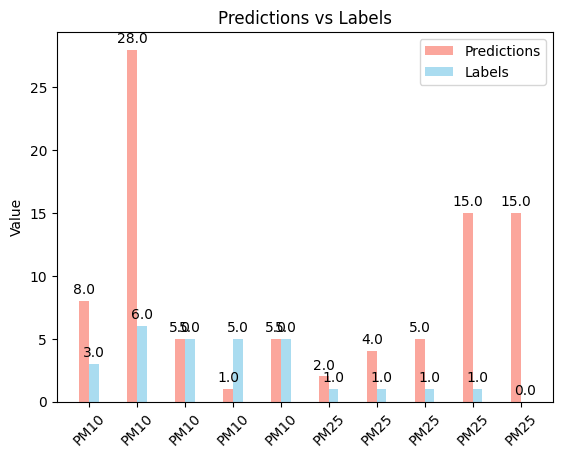

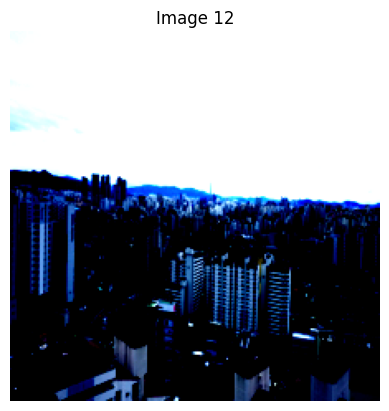

In [ ]:
# 클래스 인스턴스 생성
result = Result(pred_row, label_row, x_img, 12)

# 그래프와 이미지 표시
result.show_all(x, width, columns) #원본 이미지로 나오게 하기